## 0. Подготовка
Подключаем нужные модули и библиотеки

In [ ]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и их сохранение
import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

In [ ]:
%%time

UsageError: %%time is a cell magic, but the cell body is empty. Did you mean the line magic %time (single %)?


Определим нужное нам устройство:

In [ ]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


### 1. Загрузка датасета

Встроенными возможностями загружаем датасет [MNIST](http://yann.lecun.com/exdb/mnist/):

In [ ]:
import random as rd
inputs = []
targets = []
x = []

def yx(xi):
  y = np.sin(xi)/xi - xi/10
  return y

for i in range(1,10000):
  x = rd.randint(-500,500)/10
  inputs.append([x])
  targets.append(yx(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


In [ ]:
print(targets)
print(inputs)

[2.139840744692193, -2.632547050829325, -3.3719718245940236, 2.8226335264391618, -1.6931385055981285, -0.6827496292689577, 3.036197360528379, -3.4868997585618895, -3.448333696286814, 1.8926678670797255, 1.0083341664682814, 0.6210520793566066, -3.709423767565329, 2.008150934789449, 1.2804907119228301, 0.3501048738999706, -3.8482441724523953, 4.766908709847291, -3.4225748591007568, 0.42171994080538333, 0.9080183776121289, 4.6011719022469855, 3.5108465202439727, 4.103761565215742, nan, 0.7414709848078965, 3.458772600152689, 4.400402316479669, -1.6020036843631567, -0.7746049886192892, -1.777959306165209, 3.0486216040332965, -4.910020389423336, -1.181324426908842, 4.742267255807701, 0.8149966577360364, -3.6843389110403515, -1.2533551754393797, -4.054128402173673, 4.628527925407213, -1.5040692435862346, 2.098625843623356, -4.399597683520332, -2.4931707712139, -1.7675476611158858, 4.11146565995833, -0.7746049886192892, 2.8290931696162347, -2.8711867119539933, 1.643447206360026, -2.39247157565

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch.utils.data as data_utils

#inputs = [[ 1,  2,  3,  4,  5],[ 2,  3,  4,  5,  6]]
#targets = [ 6,7]
batch_size = 500

inputs  = torch.tensor(inputs)
targets = torch.FloatTensor(targets)
    
dataset =TensorDataset(inputs, targets)
real_data = DataLoader(dataset, batch_size, shuffle = True, drop_last = True)

Вытащим часть сэмпла и посмотри что внутри:

In [ ]:
dataiter = iter(real_data)
images, labels = dataiter.next()
images = images.numpy()

print(f'img_shape = {images[0].shape}')
print(f'lable_shape = {labels[0].size()}')
img_shape = images[0].shape
lable_shape = labels[0].size()

# np.squeeze - позволяет избавиться от размерности где равно 1 в тензоре
img = np.squeeze(images[0])
print(f'img_shape after squeeze = {img.shape}')
print(img)



img_shape = (1,)
lable_shape = torch.Size([])
img_shape after squeeze = ()
34.6


In [ ]:
img

array(34.6, dtype=float32)

### 2. Создание модели

#### 2.1 Генератор:

Генератор G предназначен для отображения вектора скрытого пространства (z) в пространство данных. Поскольку наши данные являются изображениями, преобразование z в пространство данных в конечном итоге означает создание изображения того же размера, что и обучающие изображения (то есть 1x28x28).

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Использование таких словарей позволяет нам варьировать параметры нашей сети в процессе использования
        self.activations = nn.ModuleDict([
                ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
                ['relu', nn.ReLU(0.2)]])
        
        def block(in_feat, out_feat, normalize=True, activation='relu'): #activation='relu
            layers = [nn.Linear(in_feat, out_feat)] # Если мы создаем последовательность слоев - то мы задаем их
                                                    # с помощью списка.
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(self.activations[activation]) # Эта сторчка означает тоже самое что и
                                                       # layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False), # Звездочка означает unpacking списка
            *block(128, 256, activation='lrelu'),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
        # 2

    def forward(self, z):
        img = self.model(z)
        #print(img.size())
        img = img.view(img.size(0), *img_shape)
        return img


#### ... Небольшое отступление 
Создание своих слоев. Если все правильно оформить, то созданный кастомный слой можно будет использовать внутри pytorch как обычный слой.

In [ ]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) # Обьявляем веса кка параметры слоя

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005) 
        nn.init.uniform_(self.bias, -0.005, 0.005)  

    def forward(self, x):
        # По формуле линейного слоя, нам нужно умножить наши данные на трнспонированные веса и добавить смещение
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  

nn.init.uniform_ Позволяет нам задать значения с помощью нормального распределения

#### nn.init
https://pytorch.org/docs/stable/nn.init.html

#### 2.2 Дискриминатор:

Как уже упоминалось, дискриминатор D представляет собой сеть двоичной классификации, который принимает изображение в качестве входных данных и выводит скалярную вероятность того, что входное изображение является реальным (в отличие от фальшивого). Здесь D принимает входное изображение размером 1x28x28

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(1, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        #print(f'(img {img_flat}')
        #print(img_flat.shape)
        validity = self.model(img_flat)

        return validity

# 3. Обучение

Инициализация:

In [ ]:
n_epochs = 100 # количество эпох
lr = 0.0002 # шаг обучения

b1 = 0.5 # гиперпараметр для оптимайзера Adam
b2 = 0.999 # гиперпараметр для оптимайзера Adam

latent_dim = 1 # Размерность случайного вектора, который подается на вход генератору


sample_interval = 25 # количество картинок для отображения процесса обучения

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [ ]:
d_loss_history = []
g_loss_history = []

In [ ]:
print(len(real_data))

19


Процесс обучения:

[Epoch 98/100] [Batch 13/19] [D loss: 0.013502] [G loss: 0.005555]


<Figure size 432x288 with 0 Axes>

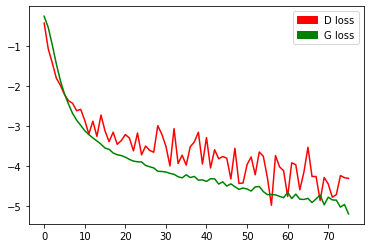

In [ ]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')



for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(real_data, start = 0):
        #print(imgs)
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)

        real_imgs = imgs.type(torch.FloatTensor).to(device)
        #if len(real_imgs) == 10:
        #  break


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        
        # Генерируем даные Генератором на основе шума
        gen_imgs = generator(z)
        
        # Подаем сгенерированые данные на Дискриминатор 
        validity = discriminator(gen_imgs)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(validity, fake)
        
        # Делаем шаг обучения нашего Генератора
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()
        
        # Получаем предсказания дискриминатора на основе реальных данных
        #print(len(real_imgs))
        real_pred = discriminator(real_imgs)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Опять делаем предсказание на Дискриминаторе с помощью сгенерированных данных
        fake_pred = discriminator(gen_imgs.detach())
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            with torch.no_grad():
                plt.clf()

                display.clear_output(wait=False)
                #sample_image(gen_imgs)
                #print(gen_imgs)
                print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 


                display.display(plt.gcf())

                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()


                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
                plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
                plt.legend(handles=[red_patch, green_patch])
                plt.show()

            

In [ ]:
torch.save(generator.state_dict(), "vanilla_gan.pth")